# Understanding User Behavior

In [2]:
from IPython.display import Image

### General Pipeline:
1. The user plays the game and with the mobile app such that the mobile application makes API calls to web services
2. The API server is used to handle the user's requests (in this case either purchasing a sword or joining a guild)
3. The API server logs these events to Kafka and these events are pulled from Kafka by Spark
4. Spark is responsible for filtering, flattening, and/or transforming these 2 events as well as writing them to Hadoop File Systems
5. We write with Spark and read with Presto but we track the schema with the Hive metastore and we expose the schemas for the purchases and joins by creating tables in the Hive metastore.
6. Presto is used to perform queries to extract insights from the events

**Events:**
1. Purchasing a Sword
2. Joining a Guild

### 1. Instrumenting your API server to log events to Kafka:**

#### a. Setup

**Ensuring that you are working in the right directory:**
cd /home/jupyter/w205/project-3-noorkaurgill

**Copying in the YML file from the Week 13 course content (Please see the annotated file at the bottom of this report):**
cp ~/w205/course-content/13-Understanding-Data/docker-compose.yml .

**Copying in the game API file from the Week 13 course content:**
cp ~/w205/course-content/13-Understanding-Data/game_api.py .

**Copying in the stream and hive python file from the Week 13a course content:**
cp ~/w205/course-content/13a/stream_and_hive.py .

**Renaming the file as purchase_sword_stream_and_hive and duplicating it as join_guild_stream_and_hive with manual edits to account for the joining a guild event.**

**Adding the other event (join a guild) to the game API file as well:**
@app.route("/join_guild") 
def join_guild():
    join_guild_event = {'event_type': 'join_guild', 'description': 'large guild'}
    log_to_kafka('events', join_guild_event)
    return "Guild Joined!\n"

#### b. Docker

**Pulling the image:** 
docker-compose pull

**Spinning up the cluster:** 
docker-compose up -d

**Viewing the state of the container:** 
docker-compose ps


#### c. Kafka Event Streaming

**Creating a topic called game_events:** 
docker-compose exec kafka kafka-topics --create --topic events --partitions 1 --replication-factor 1 --if-not-exists --zookeeper zookeeper:32181

Note: Although this was not done in this case, it is a good step to ensure that there are no duplicate name topics that relate to different information; We want to avoid creating topics automatically or in the background with Kafka bc there can be more topics of almost the same name but not the same data, which complicates things.)

#### d. Flask to Instrument API Server 

**Running the game API file on Flask with the dash host option (run our server, Flask, through the mids container and establish the environment variable for the file we'll use to run the server):**
docker-compose exec mids env FLASK_APP=/w205/project-3-noorkaurgill/game_api.py flask run --host 0.0.0.0

Note: As a security aspect, if the host isn't specified, we can only send requests from the local host. 

[NEW TERMINAL]

**Setting up kafka cat to see if everything is running right and leaving it open.
Using kafka cat to consume all the messages that come into the events topic (Note that we don’t need to create the topic - Kafka creates it with some default options):**
docker-compose exec mids kafkacat -C -b kafka:29092 -t events -o beginning

**Can also show that the topic exists and explain basic details like id, partition count, and leader:**
docker-compose exec kafka kafka-topics --describe --topic events --bootstrap-server kafka:29092

The Hive metastore is useful to track schema for tables in the Hadoop and Spark ecosystem (aka schema registry), and to expose the schema for the purchases or joins, we need to create a table in the Hive metastore. Everything that has the capacity to communicate with Hadoop, has the capacity to communicate with the Hive metastore. Since we write it with Spark and wish to read it with Presto, we must track the schema with Hive metastore, which is already spun up in our Cloudera container.

### 2. Setting up Spark to wait for and stream incoming messages continuously; using Spark streaming to filter select event types from Kafka:**

Look at purchase_sword_stream_and_hive.py and join_guild_stream_and_hive.py to see what’s needed to create the schema before filtering, which is the safest method with the least opportunity for loopholes:
- Define the purchase sword sword event schema and the join guild schema, which has the accept string, host, user agent, event type, and borrow the timestamp from Kafka (we don't inherit it from the JSON schema, but rather geet it directly from Kafka).
- is_sword_purchase is a filtering function for purchase sword event types and is_guild_join is a filtering function for join guild event types.
- Create the Spark session in the main() function, enabling with Hive
- Instead of Spark read, we use Spark readStream. Since we are reading from a stream continuously we don’t have offsets, we just have format as Kafka bootstrap servers and we subscribe to the topic events; we also register the Hive table such that we write the metadata to Hive.
- Filter out the sword purchase events and create our table with the raw event, timestamp, and JSON schema (also extracts the data but is more restrictive since we already defined the schema).
- Use Spark.sql to write and delete entries
- The sink is where the data is going in; it uses writeStream, the format is parquet, and it needs a checkpoint location, path, and trigger
- Then the loop starts
- awaitTermination is a block after which nothing will be executed. Everything prior looks for new data in a loop fashion until the process is terminated.

Note: True continuous processes don’t exist in a computer, which is a discrete machine, but this employs a writing process that is as close as it gets. 

[NEW TERMINAL] 

**Running even without inputted information:**
docker-compose exec spark spark-submit /w205/project-3-noorkaurgill/purchase_sword_stream_and_hive.py

[NEW TERMINAL] 

**Running even without inputted information:**
docker-compose exec spark spark-submit /w205/project-3-noorkaurgill/join_guild_stream_and_hive.py 

### 3. Using Apache Bench to generate test data for your pipeline:

Note: This could also be done by executing the ab bash script if you have all these commands in a bash script file (bash ab.sh).

[NEW TERMINAL]

**Running a continous statement for the number of swords assigned to user1:**
while true; do docker-compose  exec mids ab -n 10 -H "Host: user1" http://localhost:5000/purchase_a_sword; sleep 10; done


[NEW TERMINAL]

**20 swords added for user2, user1 joins 1 guild, and user 2 joins 5 guilds:**

docker-compose exec mids ab -n 20 -H "Host: user2" http://localhost:5000/purchase_a_sword

docker-compose exec mids ab -n 1 -H "Host: user1" http://localhost:5000/join_a_guild

docker-compose exec mids ab -n 5 -H "Host: user2" http://localhost:5000/join_a_guild 

Note: When we view the output in the terminal that was prior to opening this new terminal - the user agent is changed to Apache Bench instead of Pearl.

This is an example of what the output after running a statement to generate test data looks like:

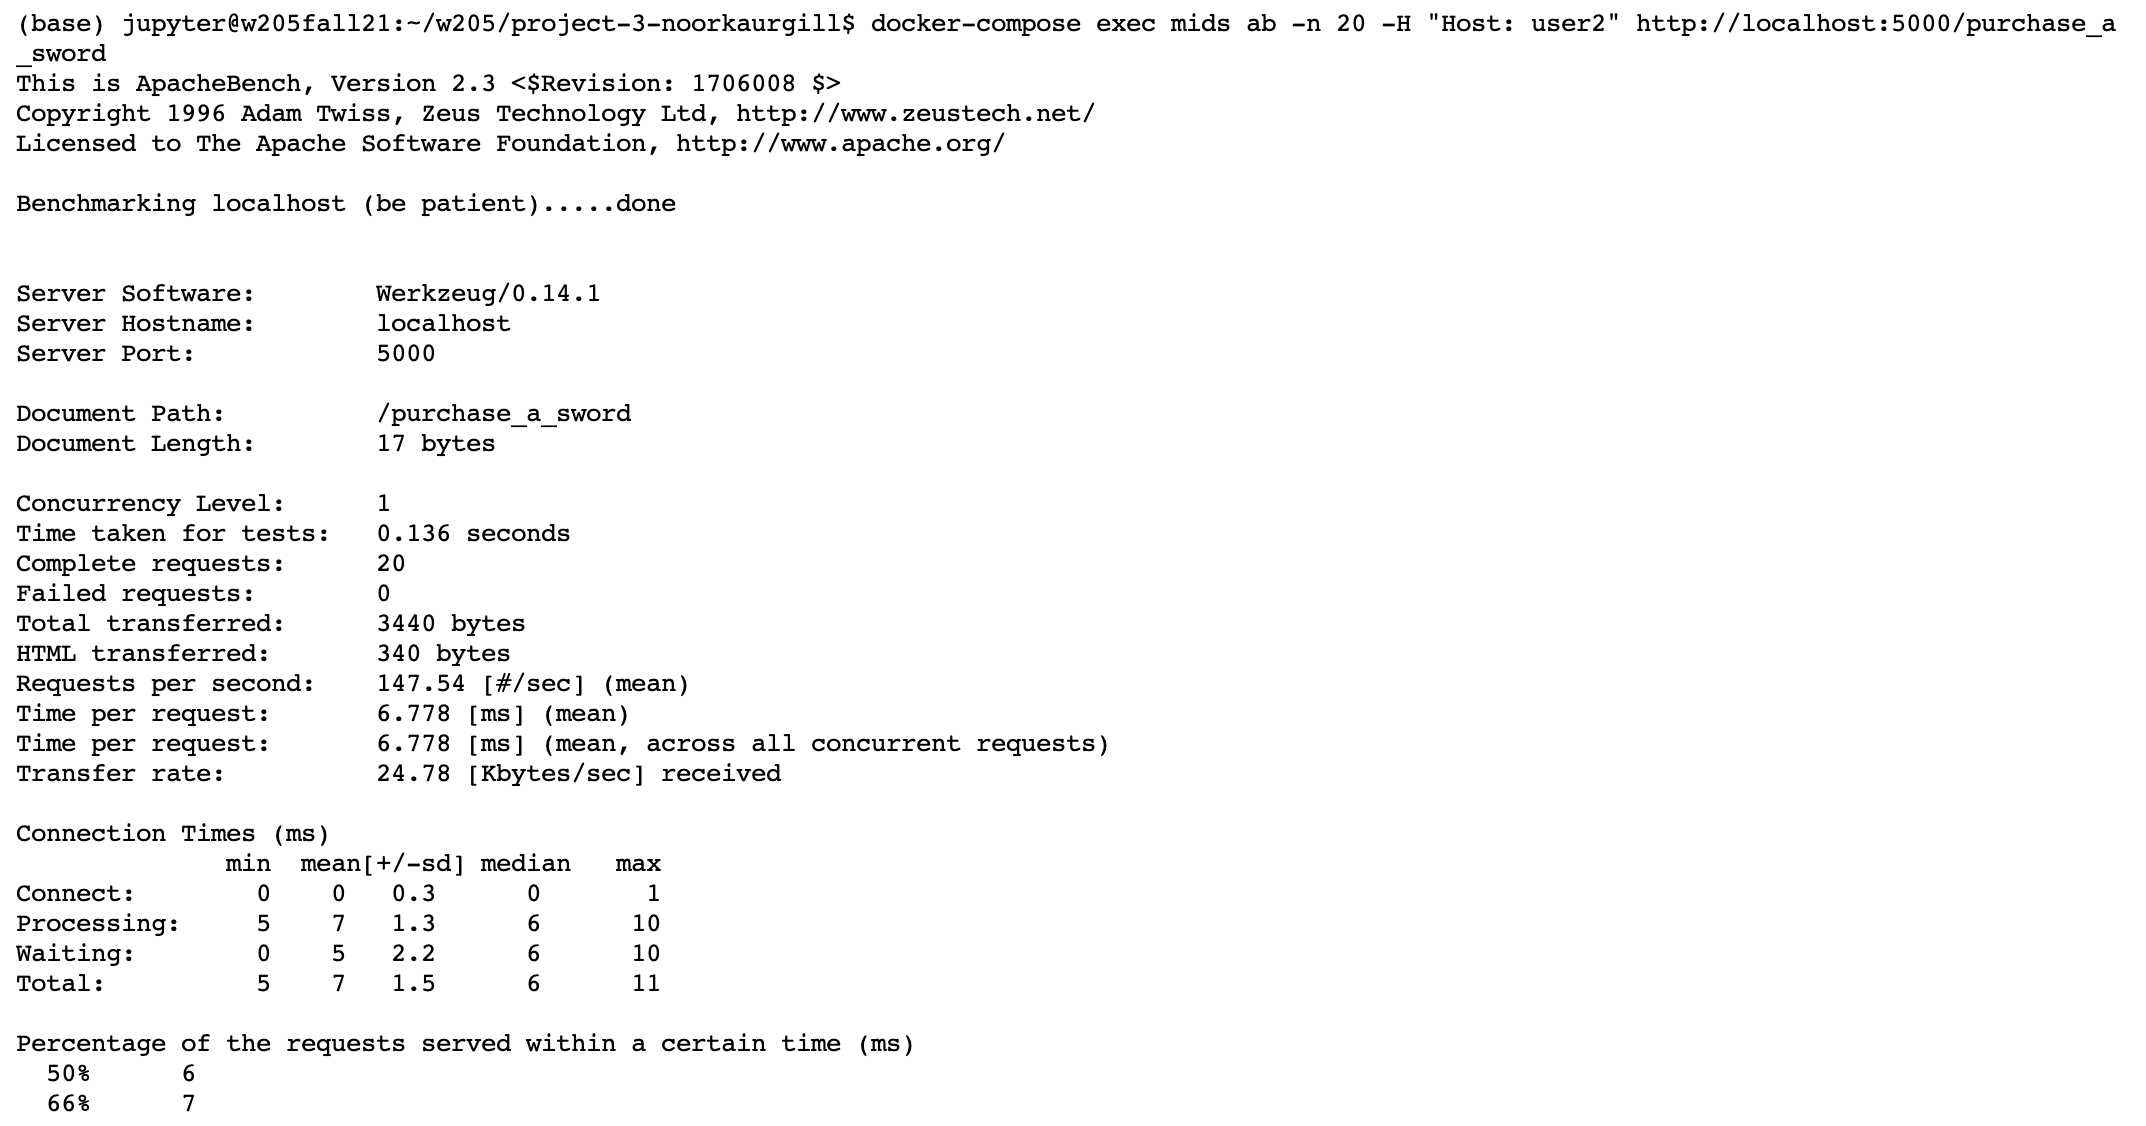

In [6]:
Image(filename='Images/1.png')

**Seeing what is landed in the purchases and joins directory in the HDFS/checking the status of what’s in Hive:**
docker-compose exec cloudera hadoop fs -ls /tmp/sword_purchases

docker-compose exec cloudera hadoop fs -ls /tmp/guild_joins

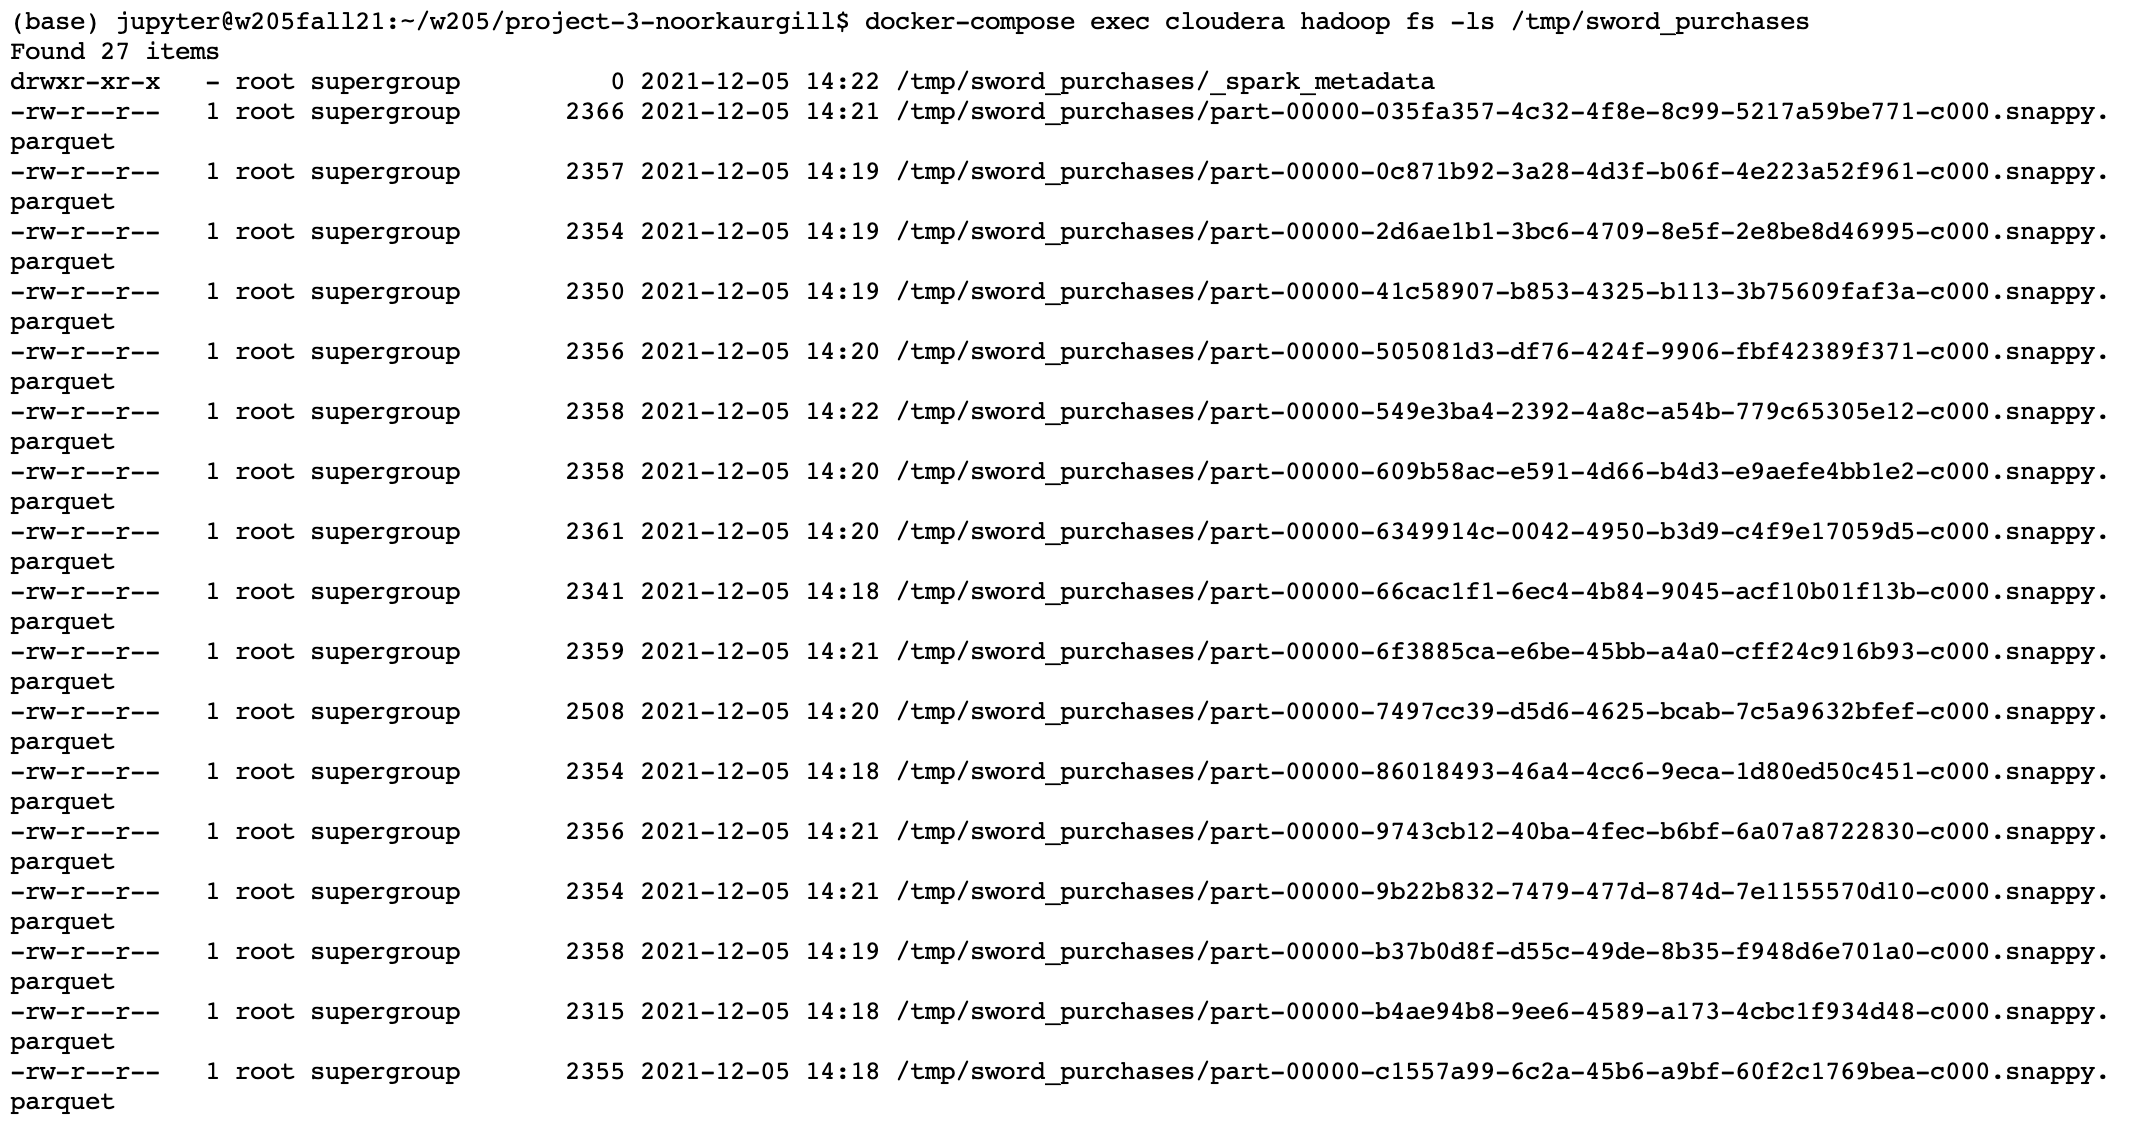

In [7]:
Image(filename='Images/2.png')

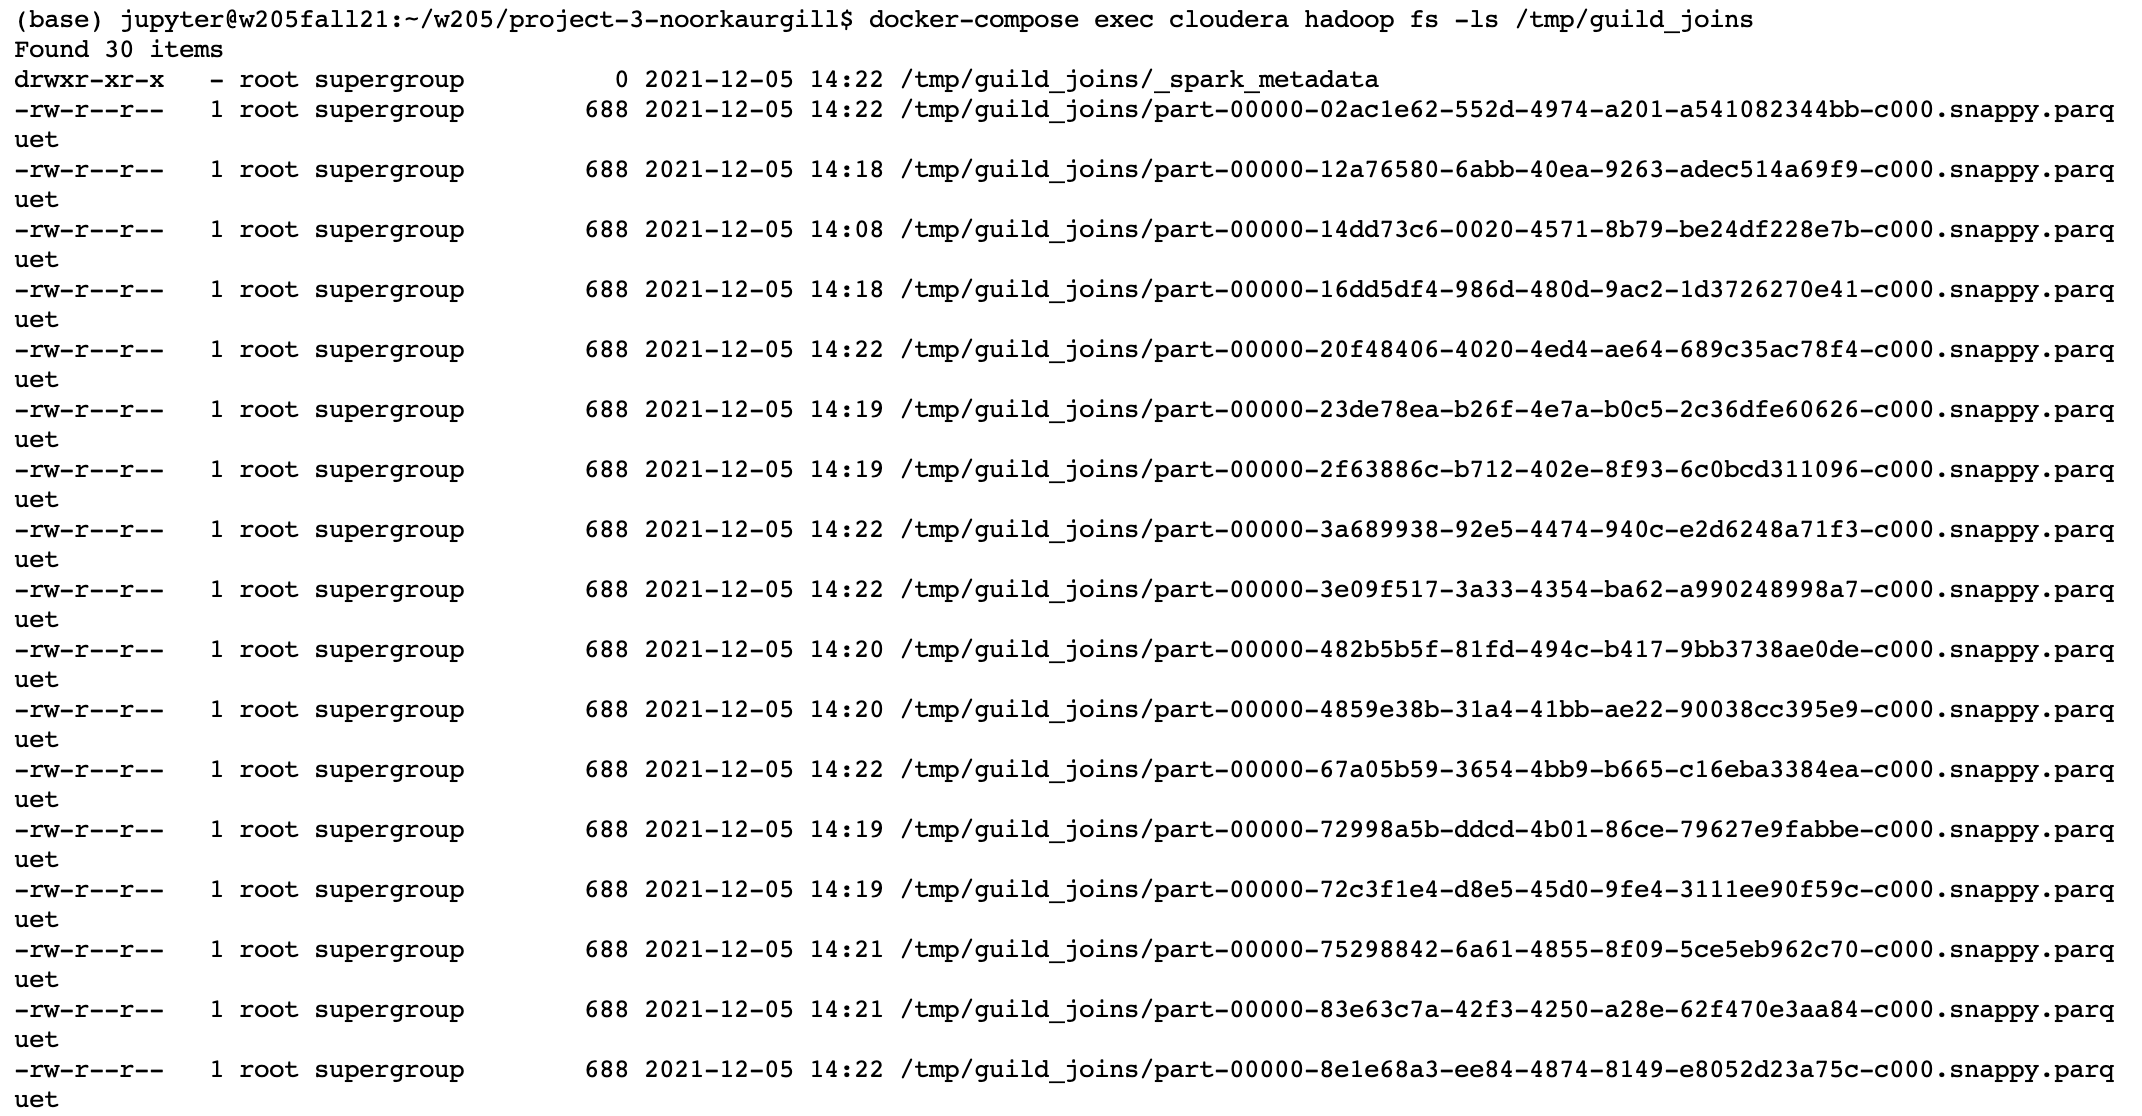

In [8]:
Image(filename='Images/3.png')

### 4. Queries & Analysis Using Presto

Presto is just a query engine that talks to the Hive thrift server to get the table we just added to HDFS to get the data. We are querying with Presto instead of Spark because Presto scales well and handles a wider range of SQL syntax.

**Run Presto:**
docker-compose exec presto --server presto:8080 --catalog hive --schema default

The tables registered should have sword_purchases and guild_joins.

1. Which users purchased a sword?

Input: `select host from sword_purchases;`

Output:

In [ ]:
host
--------
user1
user2
(2 rows)

**Recommendation:** Since both users purchased atleast one sword, having a wider range of types of swords available for purchase along with possible customizations (color, length, sharpness, brand, embellishments), would appeal to the players. 

2. Which users joined a guild?

Input: `select host from guild_joins;`

Output:

In [ ]:
host
--------
user1
user2
(2 rows)

**Recommendation:** Since both users joined atleast one guild, allowing each guild to represent a different subset of the population with its own identity and core values presentable with brief descriptions would make the process of choosing a guild more interactive for the players. There could also be a limit to the number of guilds one can join since joining a guild requires a particular level of commitment, time, and energy. 

3. What was the maximum number of guilds joined by a user and which user was it?

Input: `select host, count(event_type) as guild_count from guild_joins group by host order by count(event_type) desc`

Output:

In [ ]:
host     | guild_count
---------+------------
user2    |  5
user1    |  1
(2 rows)

**Recommendation:** Although user1 owns a lot more swords compared to user2, user1 is only part of 1 guild whereas user2 is part of 5. Therefore, user_two has more power in the game in terms of alliances and user1 has more power in the game in terms of weaponry. There could be a limit imposed for the number of swords purchased depending on the sword's length, sharpness, brand, or some other criteria, as well as a limit to the number of guilds to which a user can pledge their allegiance in order to make the game more fair for those with limited purchasing ability or any other restrictions.

**Close the cluster:**
docker-compose down

### Breakdown of YML file components: 

In [ ]:
---
version: '2'
services:
  zookeeper: # Zookeeper is an open-source server for highly reliable distributed coordination of cloud apps; it's purpose is to serve as a management tool for Kafka 
    image: confluentinc/cp-zookeeper:latest # The Zookeeper image that was downloaded most recently 
    environment:
      ZOOKEEPER_CLIENT_PORT: 32181
      ZOOKEEPER_TICK_TIME: 2000
    expose:
      - "2181"
      - "2888"
      - "32181"
      - "3888"
    extra_hosts:
      - "moby:127.0.0.1" # Establishing other hosts

  kafka: # Kafka is an open source distributed event streaming platform; hand over data to as streams and goes through the tool to make sure it’s given to someone else; acting as a distributed, decentralized data broker
    image: confluentinc/cp-kafka:latest # We are working with the latest version of Kafka (Zookeeper isn't needed and there's a distributed algorithm implemented instead)
    depends_on: # Kafka depends on Zookeeper; which order to spin up containers; personalize docker
      - zookeeper
    environment:
      KAFKA_BROKER_ID: 1 # Configuring the broker ID
      KAFKA_ZOOKEEPER_CONNECT: zookeeper:32181 # Don't need Zookeeper, can use a bootstrap server instead 
      KAFKA_ADVERTISED_LISTENERS: PLAINTEXT://kafka:29092 # Setting the listener configuration
      KAFKA_OFFSETS_TOPIC_REPLICATION_FACTOR: 1
    expose:
      - "9092"
      - "29092" # Represents the internal connection
    extra_hosts:
      - "moby:127.0.0.1" # Establishing other hosts

  cloudera: # Cloudera set-up with Hive and HDFS, the Cloudera image that was downloaded  most recently in order to run the Hadoop cluster
    image: midsw205/hadoop:0.0.2
    hostname: cloudera
    expose:
      - "8020" # nn
      - "8888" # hue
      - "9083" # hive thrift
      - "10000" # hive jdbc
      - "50070" # nn http
    ports:
      - "8888:8888"
    extra_hosts:
      - "moby:127.0.0.1" # Establishing other hosts

  spark:
    image: midsw205/spark-python:0.0.6 # The Spark image that was downloaded most recently
    stdin_open: true
    tty: true
    volumes:
      - ~/w205:/w205 # The file where project is run
    expose:
      - "8888"
    #ports:
    #  - "8888:8888"
    depends_on:
      - cloudera
    environment:
      HADOOP_NAMENODE: cloudera # Spark connects to Cloudera to Hadoop Namenode and Thriftserver (used to register tables with Hive Metastore)
      HIVE_THRIFTSERVER: cloudera:9083
    extra_hosts: # Necessary for running set-up on windows machine
      - "moby:127.0.0.1"
    command: bash # Running on a bash shell

  presto: # Contains metadata written into it, querying purposes
    image: midsw205/presto:0.0.1 # Most recent for Presto
    hostname: presto
    volumes:
      - ~/w205:/w205 # The file where project is run
    expose:
      - "8080"
    environment: 
      HIVE_THRIFTSERVER: cloudera:9083 # Presto is also connected to the Hive Thriftserver
    extra_hosts:
      - "moby:127.0.0.1" # Establishing other hosts

  mids: 
    image: midsw205/base:0.1.9 # The MIDSw205 image that was downloaded most recently
    stdin_open: true
    tty: true
    volumes:
      - ~/w205:/w205 # The file where project is run
    expose: # Runs the Flask set-up, the app server, on Port 5000
      - "5000"
    ports:
      - "5000:5000"
    extra_hosts:
      - "moby:127.0.0.1" # Establishing other hosts
